In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

## MNIST Dataset

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


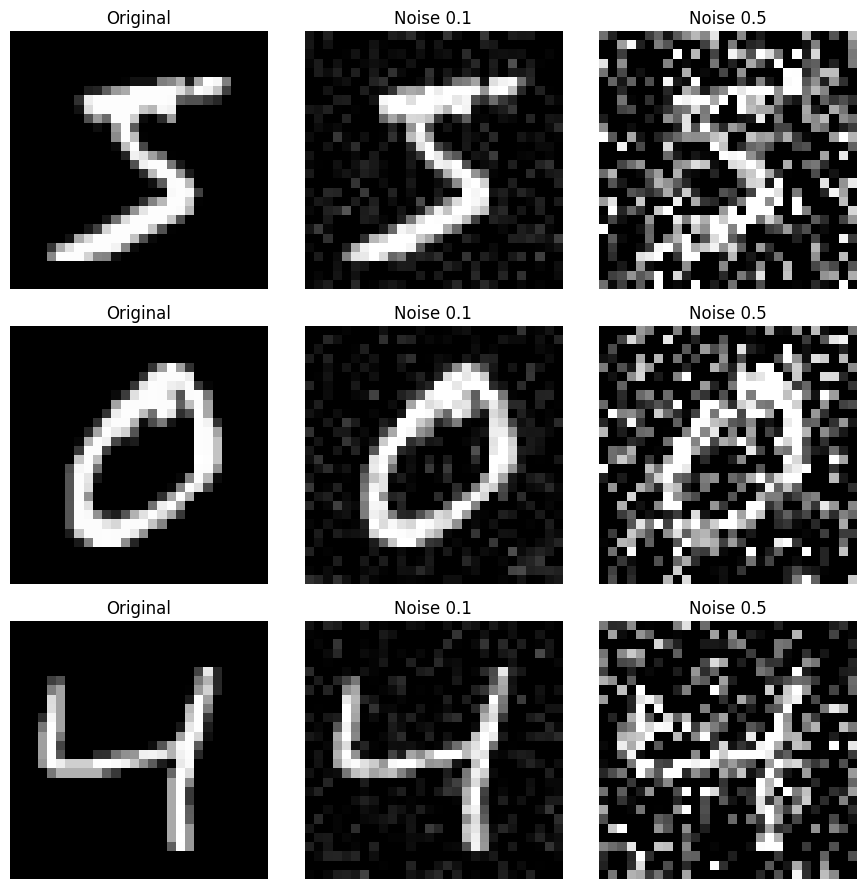

In [ ]:

# Load and preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
#Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5
x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
# Clip pixel values to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)
#Visualize in a 3 x 3 grid
n = 3 # number of images to show
plt.figure(figsize=(9, 9))
for i in range(n):
  # Original image
  ax = plt.subplot(n, 3, i * 3 + 1)
  plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
  plt.title("Original")
  plt.axis('off')
  # Low noise image
  ax = plt.subplot(n, 3, i * 3 + 2)
  plt.imshow(x_train_noisy_low[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.1")
  plt.axis('off')
  # High noise image
  ax = plt.subplot(n, 3, i * 3 + 3)
  plt.imshow(x_train_noisy_high[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.5")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def build_encoder(input_shape=(28, 28, 1)):
  """
  Builds the encoder part of the convolutional autoencoder.
  Parameters:
  input_shape (tuple): Shape of the input image. Default is (28, 28, 1) for MNIST.
  Returns:
  input_img (Keras Input): Input layer of the model.
  encoded (Keras Tensor): Encoded representation after convolution and pooling.
  """
  input_img = Input(shape=input_shape, name="input")
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)
  return input_img, encoded

In [ ]:
def build_decoder(encoded_input):
  """
  Builds the decoder part of the convolutional autoencoder.
  Parameters:
  encoded_input (Keras Tensor): The output from the encoder.
  Returns:
  decoded (Keras Tensor): The reconstructed output after upsampling and
  convolution.
  """
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)
  return decoded

In [ ]:
def build_autoencoder():
  """
  Constructs and compiles the full convolutional autoencoder by connecting encoder and
  decoder.
  Returns:
  autoencoder (Keras Model): Compiled autoencoder model.
  """
  input_img, encoded_output = build_encoder()
  decoded_output = build_decoder(encoded_output)
  autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")
  autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
  return autoencoder

In [ ]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (MaxPooling2D)          │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded (Conv2D)                │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Build the autoencoder from previous steps
autoencoder = build_autoencoder()
# Train with noisy input and clean target
history = autoencoder.fit(
x_train_noisy_high, x_train,
epochs=10,
batch_size=128,
shuffle=True,
validation_data=(x_test_noisy_high, x_test)
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.2184 - val_loss: 0.1112
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1105 - val_loss: 0.1043
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1044 - val_loss: 0.1013
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1016 - val_loss: 0.0991
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0996 - val_loss: 0.0979
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0981 - val_loss: 0.0972
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0972 - val_loss: 0.0959
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0965 - val_loss: 0.0954
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0957 - val_loss: 0.0950
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0956 - val_loss: 0.0946


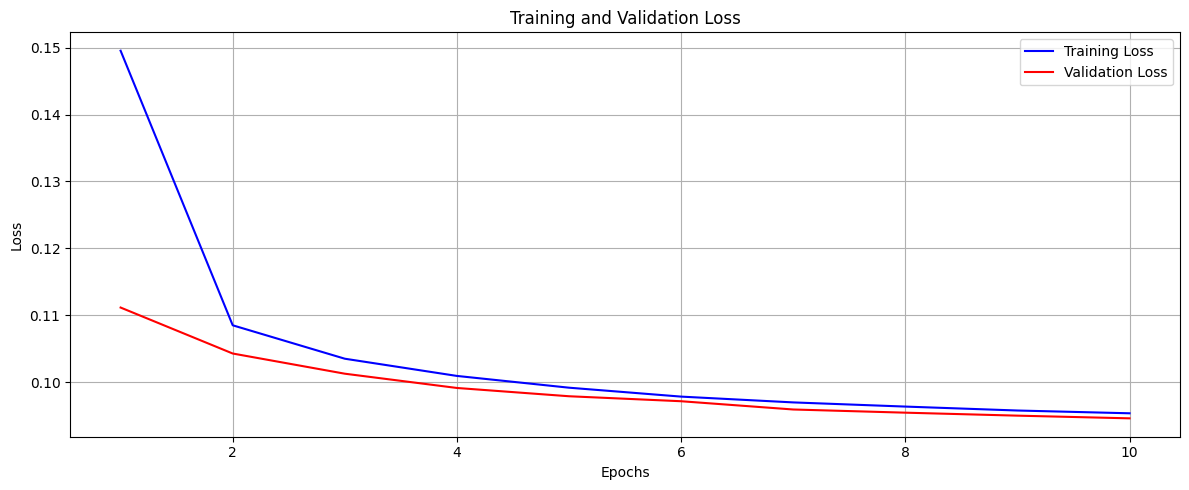

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


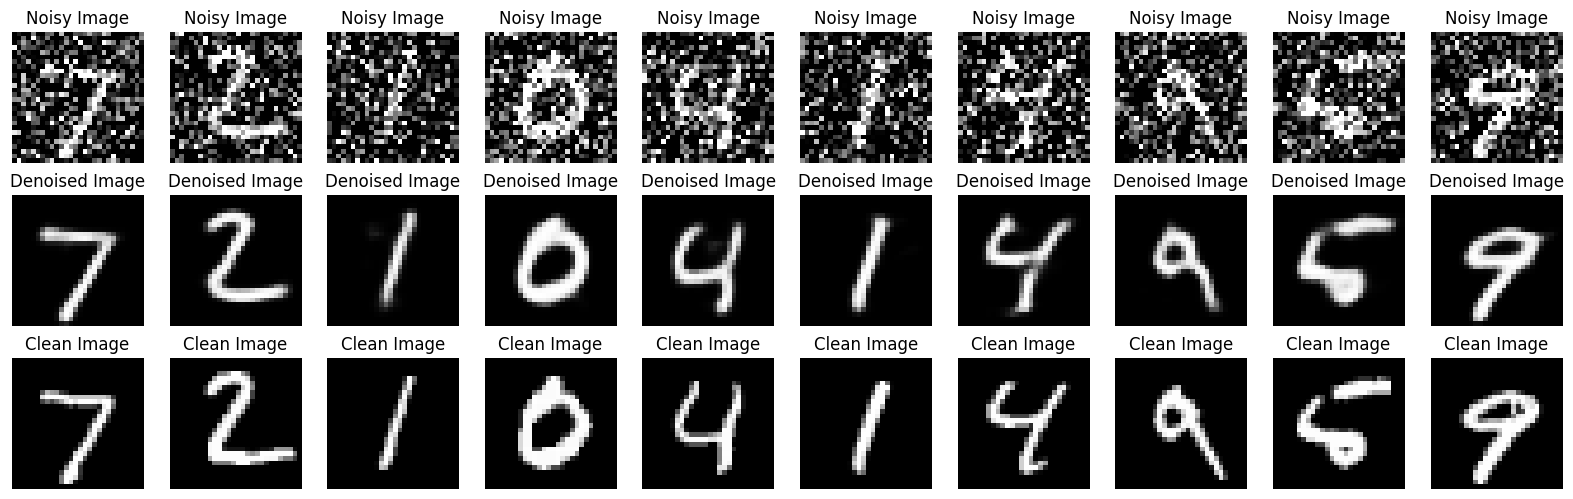

In [ ]:
# Predict the denoised images from noisy test images
denoised_images = autoencoder.predict(x_test_noisy_high)
# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
  plt.figure(figsize=(20, 6))
  for i in range(n):
  # Plot noisy images
    plt.subplot(3, n, i + 1)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy Image")
    plt.axis('off')
    # Plot denoised images
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised Image")
    plt.axis('off')
    # Plot clean images
    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
    plt.title("Clean Image")
    plt.axis('off')
  plt.show()
# Display the first 10 images
plot_images(x_test_noisy_high, denoised_images, x_test, n=10)

## Devnagari Dataset

In [13]:
# Define dataset paths
train_dir = "/content/drive/MyDrive/Copy of devnagari digit/DevanagariHandwrittenDigitDataset/Train"
test_dir = "/content/drive/MyDrive/Copy of devnagari digit/DevanagariHandwrittenDigitDataset/Test"
# Define image size
img_height, img_width = 28, 28
# Function to load images and labels using PIL
def load_images_from_folder(folder):
  images = []
  labels = []
  class_names = sorted(os.listdir(folder)) # Sorted class names (digit_0, digit_1, ...)
  class_map = {name: i for i, name in enumerate(class_names)} # Map class names to labels
  for class_name in class_names:
    class_path = os.path.join(folder, class_name)
    label = class_map[class_name]
    for filename in os.listdir(class_path):
      img_path = os.path.join(class_path, filename)
      # Load image using PIL
      img = Image.open(img_path).convert("L") # Convert to grayscale
      img = img.resize((img_width, img_height)) # Resize to (28,28)
      img = np.array(img) / 255.0 # Normalize pixel values to [0,1]

      images.append(img)
      labels.append(label)
  return np.array(images), np.array(labels)
# Load training and testing datasets
train_x, train_y = load_images_from_folder(train_dir)
test_x, test_y = load_images_from_folder(test_dir)

In [14]:
def shuffle_data(clean_images, noisy_images_low=None, noisy_images_high=None, random_seed=None):

    if random_seed is not None:
        np.random.seed(random_seed)

    # Generate shuffled indices
    num_samples = clean_images.shape[0]
    indices = np.random.permutation(num_samples)

    # Apply indices to shuffle arrays
    shuffled_clean = clean_images[indices]
    shuffled_noisy_low = noisy_images_low[indices] if noisy_images_low is not None else None
    shuffled_noisy_high = noisy_images_high[indices] if noisy_images_high is not None else None

    return (
        shuffled_clean,
        shuffled_noisy_low if noisy_images_low is not None else None,
        shuffled_noisy_high if noisy_images_high is not None else None
    )

# Example integration with your code
# Assuming x_train, x_test, etc., are already defined as in your code
# x_train, x_train_noisy_low, x_train_noisy_high = shuffle_data(
#     x_train, x_train_noisy_low, x_train_noisy_high, random_seed=42
# )
# x_test, x_test_noisy_low, x_test_noisy_high = shuffle_data(
#     x_test, x_test_noisy_low, x_test_noisy_high, random_seed=42
# )

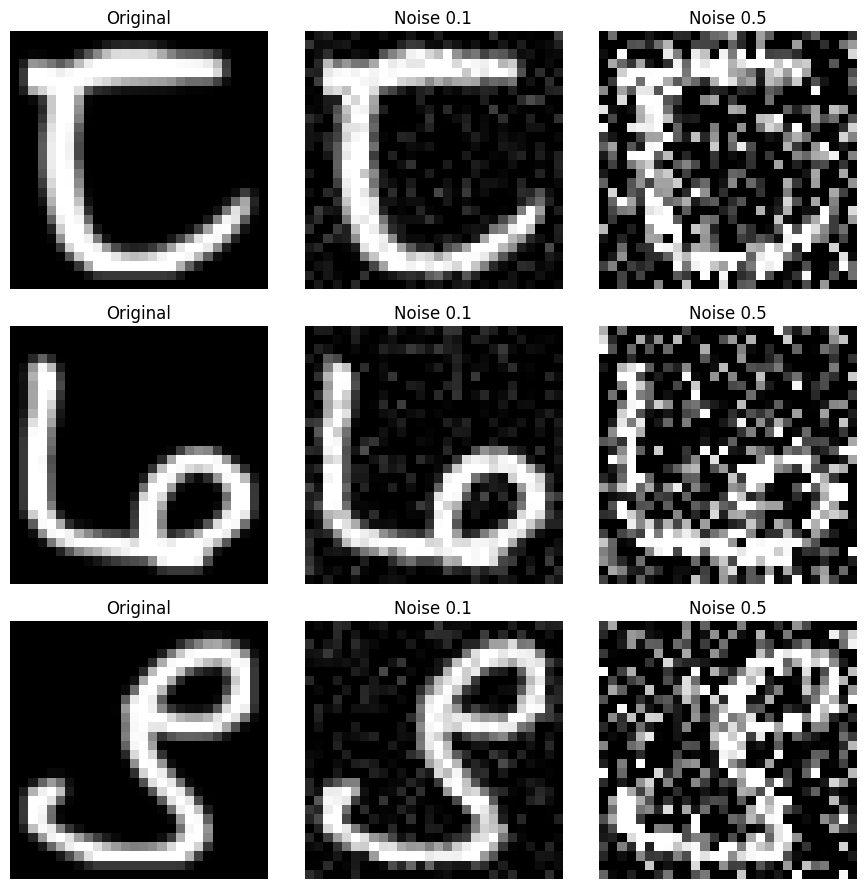

In [15]:

# Load and preprocess MNIST
x_train, x_test = train_x, test_x
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
#Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5
x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
# Clip pixel values to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)


x_train, x_train_noisy_low, x_train_noisy_high = shuffle_data(
    x_train, x_train_noisy_low, x_train_noisy_high, random_seed=42
)
x_test, x_test_noisy_low, x_test_noisy_high = shuffle_data(
    x_test, x_test_noisy_low, x_test_noisy_high, random_seed=42
)


#Visualize in a 3 x 3 grid
n = 3 # number of images to show
plt.figure(figsize=(9, 9))
for i in range(n):
  # Original image
  ax = plt.subplot(n, 3, i * 3 + 1)
  plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
  plt.title("Original")
  plt.axis('off')
  # Low noise image
  ax = plt.subplot(n, 3, i * 3 + 2)
  plt.imshow(x_train_noisy_low[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.1")
  plt.axis('off')
  # High noise image
  ax = plt.subplot(n, 3, i * 3 + 3)
  plt.imshow(x_train_noisy_high[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.5")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
def build_autoencoder():
    input_img = Input(shape=(28, 28, 1))  # Update to (32, 32, 1) if Devnagari uses 32x32
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [17]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Build the autoencoder from previous steps
autoencoder = build_autoencoder()
# Train with noisy input and clean target
history = autoencoder.fit(
x_train_noisy_high, x_train,
epochs=10,
batch_size=128,
shuffle=True,
validation_data=(x_test_noisy_high, x_test)
)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.6184
Epoch 2/10
31/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2869

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2784
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2310
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2151
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2076
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2031
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2001
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1975
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1948
Epoch 10/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1937


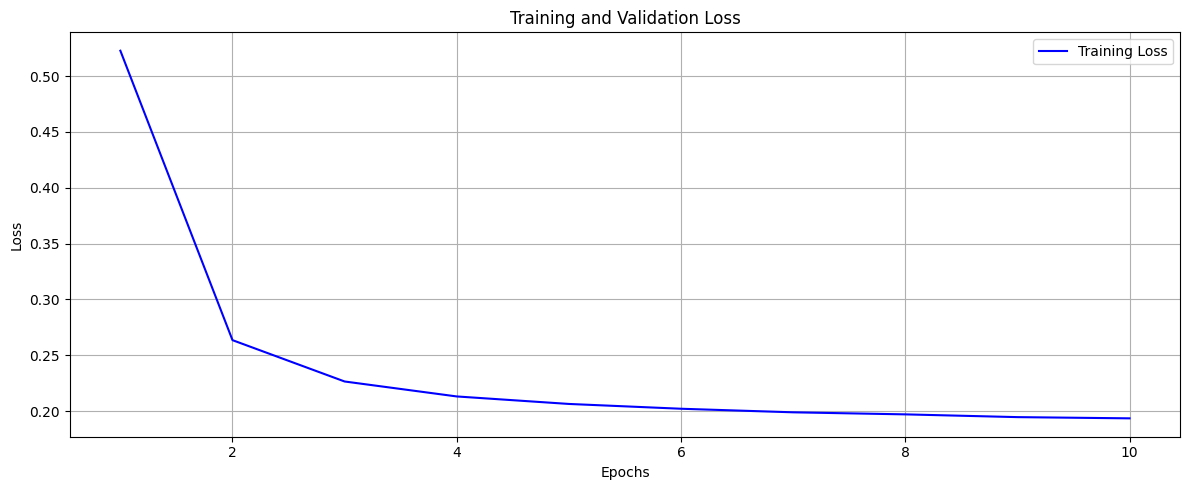

In [21]:


# Get training history
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict.get('val_loss')  # Safe retrieval

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot training loss
plt.plot(epochs, train_loss, 'b-', label='Training Loss')

# Plot validation loss if available
if val_loss is not None:
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()


In [23]:
# Check if x_test_noisy_high is valid
if x_test_noisy_high is not None and x_test_noisy_high.shape[0] > 0:
    # Predict the denoised images from noisy test images
    denoised_images = autoencoder.predict(x_test_noisy_high)

    # Function to display images
    def plot_images(noisy_images, denoised_images, clean_images, n=10):
        plt.figure(figsize=(20, 6))
        for i in range(n):
            # Plot noisy images
            plt.subplot(3, n, i + 1)
            plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
            plt.title("Noisy Image")
            plt.axis('off')
            # Plot denoised images
            plt.subplot(3, n, i + 1 + n)
            plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
            plt.title("Denoised Image")
            plt.axis('off')
            # Plot clean images
            plt.subplot(3, n, i + 1 + 2 * n)
            plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
            plt.title("Clean Image")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    # Display the first 10 images
    plot_images(x_test_noisy_high, denoised_images, x_test, n=10)

else:
    print("x_test_noisy_high is empty or invalid. Cannot perform prediction.")


x_test_noisy_high is empty or invalid. Cannot perform prediction.
